In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

# Import Data

In [2]:
teams = pd.read_csv('data/MDataFiles_Stage1/MTeams.csv')
teams.info()
teams[teams['TeamName'].str.contains('Villanova|North Carolina')] # these teams actually never met in NCAA Tournament 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
TeamID           367 non-null int64
TeamName         367 non-null object
FirstD1Season    367 non-null int64
LastD1Season     367 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.5+ KB


,TeamID,TeamName,FirstD1Season,LastD1Season
213,1314,North Carolina,1985,2020
336,1437,Villanova,1985,2020


In [3]:
seeds = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneySeeds.csv')
seeds.info()
seeds.query("TeamID == 1314") # UNC seedings through the years 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286 entries, 0 to 2285
Data columns (total 3 columns):
Season    2286 non-null int64
Seed      2286 non-null object
TeamID    2286 non-null int64
dtypes: int64(2), object(1)
memory usage: 53.7+ KB


,Season,Seed,TeamID
49,1985,Z02,1314
114,1986,Z03,1314
128,1987,W01,1314
241,1988,Z02,1314
305,1989,Z02,1314
343,1990,X08,1314
384,1991,W01,1314
499,1992,Z04,1314
512,1993,W01,1314
576,1994,W01,1314


In [4]:
tourney_results = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_results.info()
tourney_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 8 columns):
Season     2251 non-null int64
DayNum     2251 non-null int64
WTeamID    2251 non-null int64
WScore     2251 non-null int64
LTeamID    2251 non-null int64
LScore     2251 non-null int64
WLoc       2251 non-null object
NumOT      2251 non-null int64
dtypes: int64(7), object(1)
memory usage: 140.8+ KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [5]:
regular_results = pd.read_csv('data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv') 
regular_results.info()
regular_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161552 entries, 0 to 161551
Data columns (total 8 columns):
Season     161552 non-null int64
DayNum     161552 non-null int64
WTeamID    161552 non-null int64
WScore     161552 non-null int64
LTeamID    161552 non-null int64
LScore     161552 non-null int64
WLoc       161552 non-null object
NumOT      161552 non-null int64
dtypes: int64(7), object(1)
memory usage: 9.9+ MB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


# Helper Functions

In [6]:
def clf_eda_numeric(data, feature, target='Won'):
    """ Creates EDA plots for a binary target vs. a select numeric feature """
    
    # set up axes and define attributes 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
    neutral_color = list(plt.rcParams['axes.prop_cycle'])[3]['color']
    
    # top-left: boxplot 
    sns.boxplot(x=target, y=feature, data=data, ax=axes[0,0]) 
    
    # top-right: overlapping density plots, 1 for each class  
    for y in [0,1]:
        subset = data[data[target]==y]
        sns.distplot(subset[feature], label=y, ax=axes[0,1])
        xmin, xmax = data[feature].min(), data[feature].max()
        axes[0,1].set_xlim(xmin, xmax)
        axes[0,1].set_ylabel('Density')
        axes[0,1].legend()
        
    # bottom-left: line plot of average target by feature value  
    sns.lineplot(x=feature, y=target, color=neutral_color, data=data, ax=axes[1,0])
    
    # bottom-right: histogram of combined data 
    sns.distplot(data[feature], kde=False, norm_hist=True, label='Density', color=neutral_color, ax=axes[1,1])

# Construct Dataset + EDA

### Create IDs and Labels

Each observation in our dataset is a March Madness match-up between two teams in a particular season, uniquely identified by a SSSS_XXXX_YYYY ID, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team. The label of this observation is the outcome of the game, indicating whether the lower-ID team wins (1) or loses (0). 

In [7]:
def create_match_ups(seeds, seasons=None): 
    """ Given seeds dataframe and a tuple of (start, end) seasons, generate all possible match ups for each season """
    
    seeds = seeds.copy() 
    
    # filter for relevant seasons 
    if seasons is not None: 
        start_season, end_season = seasons 
        seeds = seeds[(seeds["Season"] >= start_season) & (seeds["Season"] <= end_season)]
        
    # generate pairwise match-ups 
    pairs = seeds\
        .merge(seeds, how='left', on=['Season'], suffixes=['_A', '_B'])\
        .drop(['Seed_A', 'Seed_B'], axis=1)\
        .query("TeamID_A < TeamID_B")\
        .rename(columns={'TeamID_A': 'TeamA', 'TeamID_B': 'TeamB'})\
        .assign(Teams = lambda x: x['TeamA'].astype(str) + '_' + x['TeamB'].astype(str))\
        .assign(ID = lambda x: x['Season'].astype(str) + '_' + x['Teams'])
        
    return pairs

def reformat_tourney_results(tourney_results):
    """ Reformat tournament results into a more useful format (WTeamID/LTeamID --> TeamA/TeamB) """
    
    reformatted = tourney_results.assign(
        TeamA = lambda x: x[['WTeamID','LTeamID']].min(axis=1), 
        TeamB = lambda x: x[['WTeamID','LTeamID']].max(axis=1), 
        Teams = lambda x: x['TeamA'].astype(str) + '_' + x['TeamB'].astype(str),
        ID = lambda x: x['Season'].astype(str) + '_' + x['Teams'],
        Won = lambda x: np.where(x['WTeamID'] < x['LTeamID'], 1, 0),
        ScoreTeamA = lambda x: np.where(x['WTeamID'] == x['TeamA'], x['WScore'], x['LScore']),
        ScoreTeamB = lambda x: np.where(x['WTeamID'] == x['TeamB'], x['WScore'], x['LScore']),
        ScoreDiff = lambda x: x['ScoreTeamA'] - x['ScoreTeamB']
    )
    
    cols_to_return = ['ID', 'Season', 'TeamA', 'TeamB', 'Teams', 'Won', 
                      'ScoreTeamA', 'ScoreTeamB', 'ScoreDiff', 'DayNum', 'NumOT', 'WLoc']
    
    return reformatted[cols_to_return] 

def append_labels(pairs, tourney_results_reformatted):
    """ Given set of all possible match-ups, reduce to pairs with historical results, and append relevant labels """
    labeled = pairs.merge(tourney_results_reformatted[['ID', 'Won']], how='inner', on='ID')
    return labeled

In [8]:
# reformat tournament results - to be used to generate historical features later 
tourney_results_reformatted = reformat_tourney_results(tourney_results)
tourney_results_reformatted.head()

,ID,Season,TeamA,TeamB,Teams,Won,ScoreTeamA,ScoreTeamB,ScoreDiff,DayNum,NumOT,WLoc
0,1985_1116_1234,1985,1116,1234,1116_1234,1,63,54,9,136,0,N
1,1985_1120_1345,1985,1120,1345,1120_1345,1,59,58,1,136,0,N
2,1985_1207_1250,1985,1207,1250,1207_1250,1,68,43,25,136,0,N
3,1985_1229_1425,1985,1229,1425,1229_1425,1,58,55,3,136,0,N
4,1985_1242_1325,1985,1242,1325,1242_1325,1,49,38,11,136,0,N


In [9]:
pairs = create_match_ups(seeds, seasons=(1985, 2019))
labeled_pairs = append_labels(pairs, tourney_results_reformatted)
print("There are {} possible match-ups, but only {} were realized and have labels to train with!".format(
    len(pairs), len(labeled_pairs)))

There are 73558 possible match-ups, but only 2251 were realized and have labels to train with!


In [10]:
labeled_pairs.info()
display(labeled_pairs.query("Teams == '1314_1437'")) # UNC-Villanova head-to-heads 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2251 entries, 0 to 2250
Data columns (total 6 columns):
Season    2251 non-null int64
TeamA     2251 non-null int64
TeamB     2251 non-null int64
Teams     2251 non-null object
ID        2251 non-null object
Won       2251 non-null int64
dtypes: int64(4), object(2)
memory usage: 123.1+ KB


,Season,TeamA,TeamB,Teams,ID,Won
50,1985,1314,1437,1314_1437,1985_1314_1437,0
378,1991,1314,1437,1314_1437,1991_1314_1437,1
1312,2005,1314,1437,1314_1437,2005_1314_1437,1
1535,2009,1314,1437,1314_1437,2009_1314_1437,1
1807,2013,1314,1437,1314_1437,2013_1314_1437,1
1986,2016,1314,1437,1314_1437,2016_1314_1437,0


### Create Seed Features

Here we append three features to our dataset: seedings of the respective teams for that season (`SeedA` for the lower-ID team and `SeedB` for the higher-ID team) and the difference between the two (`SeedDiff`=SeedB-SeedA). We expect the latter to be one of the most predictive features of the game outcome. 

In [11]:
def append_seed_features(data, seeds):
    """ Create seed features and append to main dataframe """
    seeds = seeds.copy() 
    seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
    seeds = seeds.set_index(['Season', 'TeamID'])
    df = data.merge(seeds, how='left', left_on=['Season', 'TeamA'], right_index=True)\
             .merge(seeds, how='left', left_on=['Season', 'TeamB'], right_index=True, suffixes=('A', 'B'))
    df['SeedDiff'] = df['SeedB'] - df['SeedA'] 
    return df 

In [12]:
labeled_pairs_w_seeds = append_seed_features(labeled_pairs, seeds)
labeled_pairs_w_seeds.query("Teams == '1314_1437'")

,Season,TeamA,TeamB,Teams,ID,Won,SeedA,SeedB,SeedDiff
50,1985,1314,1437,1314_1437,1985_1314_1437,0,2,8,6
378,1991,1314,1437,1314_1437,1991_1314_1437,1,1,9,8
1312,2005,1314,1437,1314_1437,2005_1314_1437,1,1,5,4
1535,2009,1314,1437,1314_1437,2009_1314_1437,1,1,3,2
1807,2013,1314,1437,1314_1437,2013_1314_1437,1,8,9,1
1986,2016,1314,1437,1314_1437,2016_1314_1437,0,1,2,1


Not surprisingly, the higher a team is seeded, the more likely it is to win. 

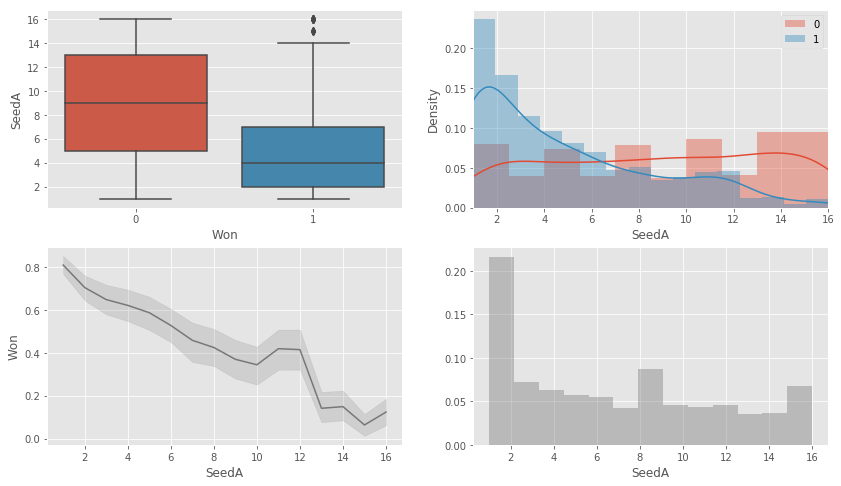

In [13]:
clf_eda_numeric(labeled_pairs_w_seeds, feature='SeedA')

Conversely, the higher a team's opponent is seeded, the less likely a team is to win. 

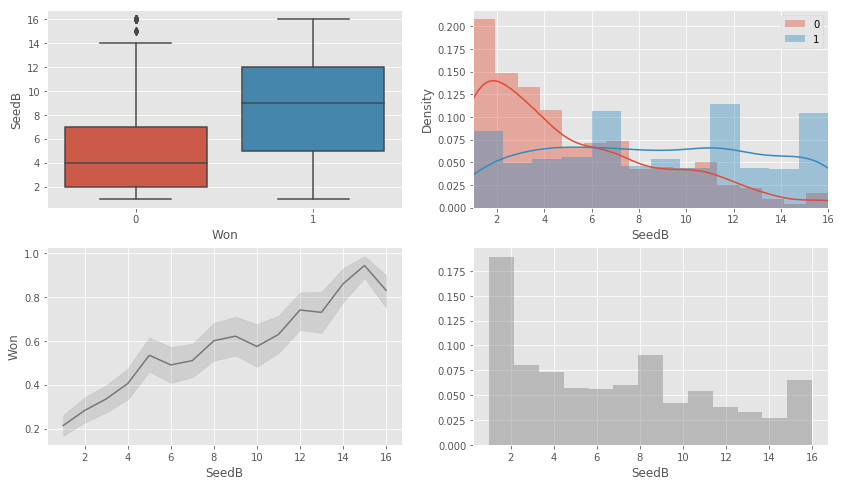

In [14]:
clf_eda_numeric(labeled_pairs_w_seeds, feature='SeedB')

Perhaps the relative seeding of the teams is the most telling: conventional wisdom assumes the higher-seeded team wins, and the greater the gap in seedings, the higher the probability of winning. Our EDA below appears mostly consistent with our intuition.

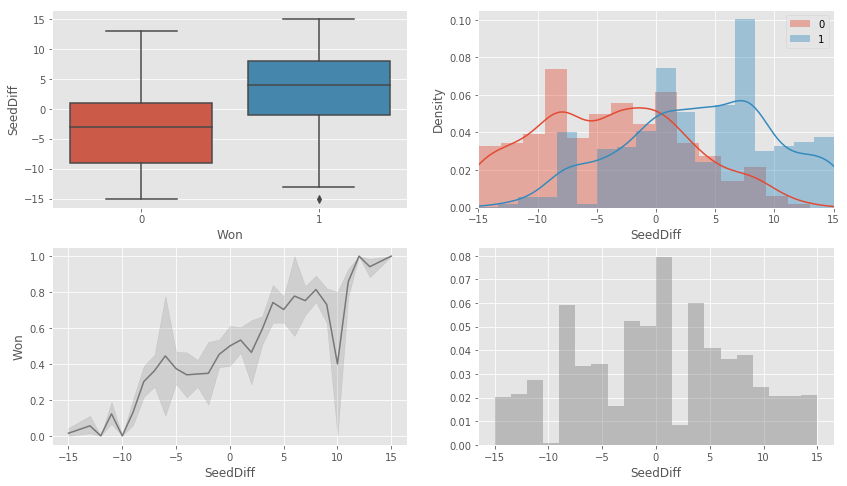

In [15]:
clf_eda_numeric(labeled_pairs_w_seeds, feature='SeedDiff')

### Create historical tourney head-to-head features 

In [83]:
def bayesian_adj(n_wins, n_games, a=1, b=1):
    """ Apply a simple Bayesian adjustment for computing win rate, as (n_wins + a) / (n_games + a + b) """ 
    return (n_wins + a) / (n_games + a + b)

In [92]:
def append_tourney_head_to_head(data, tourney_results_reformatted):
    """ Given data w/ tourney results, append head-to-head features """
    
    # if data contains label, remove before joining
    df = data.copy()
    if 'Won' in df.columns: 
        df = df.drop('Won', axis=1)
    
    # generate head-to-head metrics 
    tourney_h2h = df\
        .merge(tourney_results_reformatted, how='left', on='Teams', suffixes=('_1', '_2'))\
        .query("Season_1 > Season_2")\
        .groupby(['Teams', 'Season_1'])\
        .agg({'Won': ['size', np.sum], 'ScoreDiff': [np.sum]})\
        .reset_index()
    tourney_h2h.columns = ['Teams', 'Season', 'TourneyH2HTotal', 'TourneyH2HWins', 'TourneyH2HScoreDiff']
    tourney_h2h['TourneyH2HLosses'] = tourney_h2h['TourneyH2HTotal'] - tourney_h2h['TourneyH2HWins']
    tourney_h2h['TourneyH2HEdge'] = tourney_h2h['TourneyH2HWins'] - tourney_h2h['TourneyH2HLosses']
    
    # append to main dataframe 
    output = data.merge(tourney_h2h, how='left', on=['Season','Teams']).fillna(0)
    for col in ['TourneyH2HTotal', 'TourneyH2HWins', 'TourneyH2HLosses', 'TourneyH2HEdge', 
                'TourneyH2HScoreDiff']:
        output[col] = output[col].astype(int)
    output['TourneyH2HWinRateAdj'] = output.apply(
        lambda x: bayesian_adj(x['TourneyH2HWins'], x['TourneyH2HTotal']), axis=1)
    
    return output

In [93]:
labeled_pairs_w_h2h = append_tourney_head_to_head(labeled_pairs_w_seeds, tourney_results_reformatted)
labeled_pairs_w_h2h.query("Teams == '1314_1437'").T

,50,378,1312,1535,1807,1986
Season,1985,1991,2005,2009,2013,2016
TeamA,1314,1314,1314,1314,1314,1314
TeamB,1437,1437,1437,1437,1437,1437
Teams,1314_1437,1314_1437,1314_1437,1314_1437,1314_1437,1314_1437
ID,1985_1314_1437,1991_1314_1437,2005_1314_1437,2009_1314_1437,2013_1314_1437,2016_1314_1437
Won,0,1,1,1,1,0
SeedA,2,1,1,1,8,1
SeedB,8,9,5,3,9,2
SeedDiff,6,8,4,2,1,1
TourneyH2HTotal,0,1,2,3,4,5


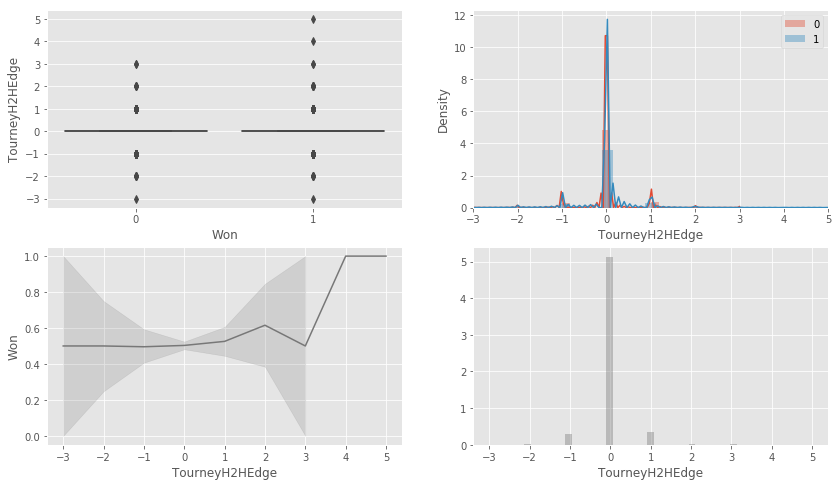

In [94]:
clf_eda_numeric(labeled_pairs_w_h2h, feature='TourneyH2HEdge')

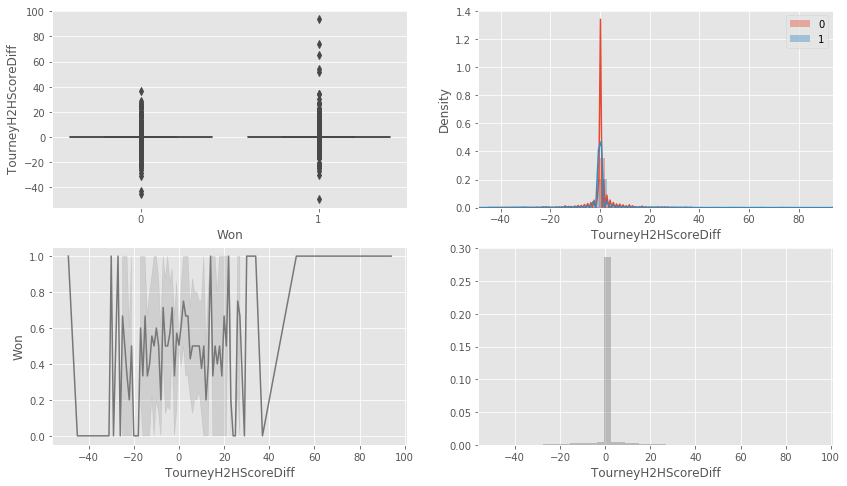

In [95]:
clf_eda_numeric(labeled_pairs_w_h2h, feature='TourneyH2HScoreDiff')

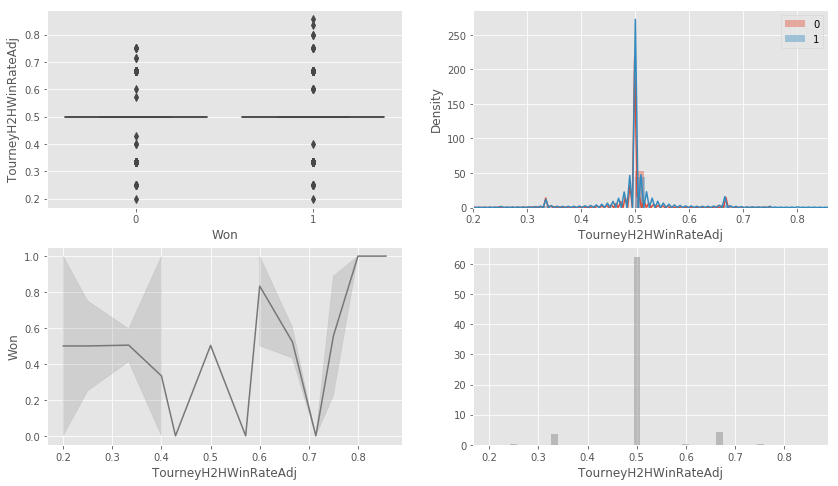

In [96]:
clf_eda_numeric(labeled_pairs_w_h2h, feature='TourneyH2HWinRateAdj')

### Put It Altogether

In [97]:
DATA = {'seeds': pd.read_csv('data/MDataFiles_Stage1/MNCAATourneySeeds.csv'), 
        'tourney_results': pd.read_csv('data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')}

In [98]:
def construct_dataset(seasons, train=True, ignore_before=None, input_data=DATA):
    """ Given a range of seasons to train/predict on, chain together data wrangling steps to generate train/test 
        datasets from raw data. 
    
        Parameters
        ----------
        seasons : tuple
            A tuple (season_start, season_end) specifying which seasons we want to include in our train/test sets 
        ignore_before : int, default=None
            Data from seasons prior to ignore_before will not be used to engineer features (e.g. historical win %)
        train : boolean, default=True 
            If train=True, only realized match-ups will be returned, along with their match outcomes as labels. 
            If train=False, all possible match-ups will be returned, with no labels. 
            
        Returns
        -------
        dataset : pd.DataFrame
            Either a train or test dataset with a complete set of engineered features 
    """
    
    # parse input 
    seeds, tourney_results = input_data['seeds'], input_data['tourney_results']
    season_start, season_end = seasons 
    
    # generate matchups 
    df = create_match_ups(seeds, seasons=seasons)
    
    # discard data from older seasons 
    if ignore_before:
        tourney_results = tourney_results[tourney_results['Season'] >= ignore_before ]
    
    # engineer and append features 
    tourney_results_reformatted = reformat_tourney_results(tourney_results)
    df = append_seed_features(df, seeds)
    df = append_tourney_head_to_head(df, tourney_results_reformatted)
    
    if train is True: 
        df = append_labels(df, tourney_results_reformatted)
    
    return df

# Fit Model

### Helper Functions 

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone 
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, balanced_accuracy_score, \
    precision_score, recall_score, f1_score, roc_curve, precision_recall_curve

In [100]:
# here we define a train/test split function to use all data preceding each season to train a model 

def train_test_period_split(data, season_to_predict, season_to_start=1985): 
    """ Split data into train vs. test datasets. 
        - Test set comprises only the single season specified; 
        - Train set comprises all data between season_to_start through the season before the one to predict on 
    """
    
    train_data = data.query("Season >= @season_to_start & Season < @season_to_predict")
    test_data = data.query("Season == @season_to_predict")

    return train_data, test_data

In [101]:
def iterative_train(model, seasons_to_predict, data, features, season_to_start=1985): 
    """ For each season to predict, instantiate the model and fit to a different train set using all prior seasons 
        (beginning from season_to_start). Returns a dictionary with {season:model} value pairs. 
    """
    models = {} 
    for season in seasons_to_predict:
        train_data, _ = train_test_period_split(data, season, season_to_start)
        X_train, y_train = train_data[features], train_data['Won']
        models[season] = clone(model)
        models[season].fit(X_train, y_train)
    
    return models 

def iterative_predict(models, seasons_to_predict, data, features, season_to_start=1985):
    """ Iterate over list of models and predict on each relevant season. 
        Returns a subset of data (of relevant seasons) with prediction appended as a new column. 
    """
    pred_dfs = []
    
    for season in seasons_to_predict: 
        _, test_data = train_test_period_split(data, season)
        df = test_data.copy() 
        df['Pred'] = models[season].predict_proba(df[features])[:,1]
        pred_dfs.append(df)
        
    return pd.concat(pred_dfs)

In [102]:
def evaluate_predictions(y_true, y_score, cls_threshold=.5, plot=False):
    """ Given labels and predictions, return a dictionary with classifier evaluation metrics. 
        Optionally, plot ROC and Precision-Recall curves. 
    """
    
    y_pred = y_score > cls_threshold
    metrics = {} 
    metrics['LogLoss'] = log_loss(y_true, y_score)
    metrics['AuROC'] = roc_auc_score(y_true, y_score)
    metrics['AuPR'] = average_precision_score(y_true, y_score)
    metrics['BalancedAcc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1'] = f1_score(y_true, y_pred)
    
    if plot: 
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
        color1 = list(plt.rcParams['axes.prop_cycle'])[0]['color']
        color2 = list(plt.rcParams['axes.prop_cycle'])[1]['color']
        
        # TODO: refactor curve plotting code 
        # plot roc curve 
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        axes[0].plot(fpr, tpr, color=color1, lw=2, 
                     label='ROC curve (AuROC = %0.3f)' % metrics['AuROC'])
        axes[0].plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='No Skill')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('ROC Curve')
        axes[0].legend(loc="lower right")
        
        # plot precision-recall curve 
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_score)
        axes[1].plot(recalls, precisions, color=color2, lw=2, 
                     label='Precision-Recall Curve (AuPR = %0.3f)' % metrics['AuPR'])
        no_skill = sum(y_true) / len(y_true)
        axes[1].plot([0, 1], [no_skill, no_skill], color='grey', lw=2, linestyle='--', label='No Skill')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Precision-Recall Curve')
        axes[1].legend(loc="lower right")        
        
    return metrics 

In [103]:
train_data = construct_dataset(seasons=(1985, 2019))
seasons_to_predict = [2015,2016,2017,2018,2019]

### Baseline Model (1): Logistic Regression w/ SeedDiff Only

{'LogLoss': 0.5603291519585382,
 'AuROC': 0.7825540472599297,
 'AuPR': 0.7511344462801287,
 'BalancedAcc': 0.7065287653522947,
 'Precision': 0.6464088397790055,
 'Recall': 0.7647058823529411,
 'F1': 0.7005988023952096}

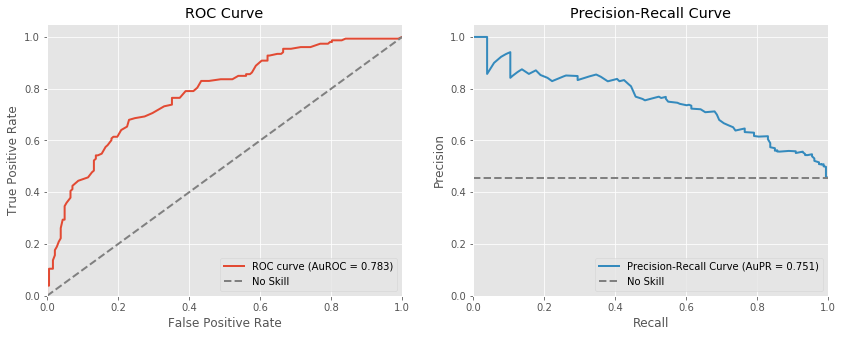

In [104]:
lr1_features = ['SeedDiff']
lr1 = LogisticRegression()
lr1_models = iterative_train(lr1, seasons_to_predict, train_data, lr1_features)
lr1_preds = iterative_predict(lr1_models, seasons_to_predict, train_data, lr1_features)
evaluate_predictions(lr1_preds['Won'], lr1_preds['Pred'], cls_threshold=.5, plot=True)

{'LogLoss': 0.5596707921806555,
 'AuROC': 0.7837750484809309,
 'AuPR': 0.753001148701228,
 'BalancedAcc': 0.7147705235940529,
 'Precision': 0.6573033707865169,
 'Recall': 0.7647058823529411,
 'F1': 0.7069486404833837}

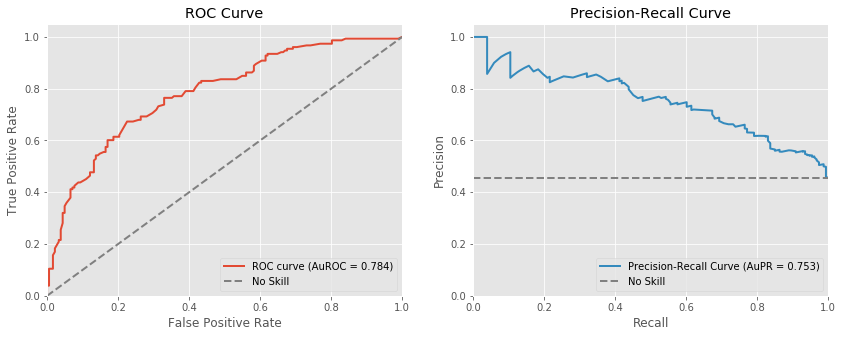

In [109]:
lr2_features = ['SeedDiff','TourneyH2HEdge']
lr2 = LogisticRegression()
lr2_models = iterative_train(lr2, seasons_to_predict, train_data, lr2_features)
lr2_preds = iterative_predict(lr2_models, seasons_to_predict, train_data, lr2_features)
evaluate_predictions(lr2_preds['Won'], lr2_preds['Pred'], cls_threshold=.5, plot=True)

{'LogLoss': 0.5598064359237113,
 'AuROC': 0.7835236658766069,
 'AuPR': 0.7528684586984817,
 'BalancedAcc': 0.7147705235940529,
 'Precision': 0.6573033707865169,
 'Recall': 0.7647058823529411,
 'F1': 0.7069486404833837}

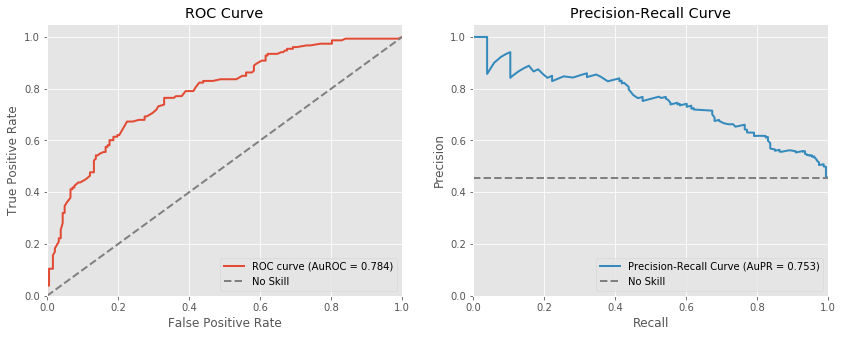

In [111]:
lr2_features = ['SeedDiff','TourneyH2HEdge','TourneyH2HWinRateAdj']
lr2 = LogisticRegression()
lr2_models = iterative_train(lr2, seasons_to_predict, train_data, lr2_features)
lr2_preds = iterative_predict(lr2_models, seasons_to_predict, train_data, lr2_features)
evaluate_predictions(lr2_preds['Won'], lr2_preds['Pred'], cls_threshold=.5, plot=True)

# Output Predictions

Here we output the predictions in the format required by Kaggle. For every possible pair-wise matchup between teams that qualified for March Madness each season, we need to predict the probability that the lower-ID team wins. Our prediction output comprises a CSV with two columns: ID, Pred 

In [60]:
# check submission format for Round 1 
sample_pred = pd.read_csv('data/MSampleSubmissionStage1_2020.csv')
display(sample_pred.head())
print(len(sample_pred))

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


11390


In [61]:
# TODO: create a function 
# TODO: refactor seasons_to_predict to use same input as create_match_ups
# TODO: double check contains same IDs as sample predictions, maybe also reorder 
new = create_match_ups(seeds, seasons=[2015,2019])
new = append_seed_features(new, seeds)
new = append_tourney_head_to_head(new, tourney_results_reformatted)
new_preds = iterative_predict(lr2_models, seasons_to_predict, new, lr2_features)
new_preds = new_preds[['ID', 'Pred']]
display(new_preds.head())
new_preds.to_csv('my_predictions_stage1.csv', index=False)

,ID,Pred
0,2015_1437_1438,0.558555
1,2015_1437_1461,0.871327
2,2015_1437_1452,0.676675
3,2015_1437_1455,0.745361
4,2015_1437_1458,0.516883
